In [29]:
import os
import seaborn as sb
df = sb.load_dataset('taxis')
os.environ['THEME'] = 'light'

🔵 *** df: dataframe ***
🟣 shape: (6_433, 14) columns: ['pickup', 'dropoff', 'passengers', 'distance', 'fare', 'tip', 'tolls', 'total', 'color', 'payment', 'pickup_zone', 'dropoff_zone', 'pickup_borough', 'dropoff_borough'] 
🟣 duplicates: 0
🟣 missings: {'pickup': 0, 'dropoff': 0, 'passengers': 0, 'distance': 0, 'fare': 0, 'tip': 0, 'tolls': 0, 'total': 0, 'color': 0, 'payment': 44, 'pickup_zone': 26, 'dropoff_zone': 45, 'pickup_borough': 26, 'dropoff_borough': 45}
--- column uniques (all)
🟠 index [0, 1, 2, 3, 4,]
🟠 pickup(6_414|datetime64[ns]) [2019-02-28 23:29:03, 2019-03-01 00:03:29, 2019-03-01 00:08:32, 2019-03-01 00:15:53, ]
🟠 dropoff(6_425|datetime64[ns]) [2019-02-28 23:32:35, 2019-03-01 00:13:32, 2019-03-01 00:29:47, 2019-03-01 00:32:48, ]
🟠 passengers(7|int64) [0, 1, 2, 3, 4,]
🟠 distance(1_079|float64) [0.0, 0.01, 0.02, 0.03, 0.04,]
🟠 fare(220|float64) [1.0, 2.5, 3.0, 3.5, 4.0,]
🟠 tip(489|float64) [0.0, 0.01, 0.02, 0.06, 0.08,]
🟠 tolls(16|float64) [0.0, 2.64, 4.75, 5.54, 5.75,]
🟠

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan


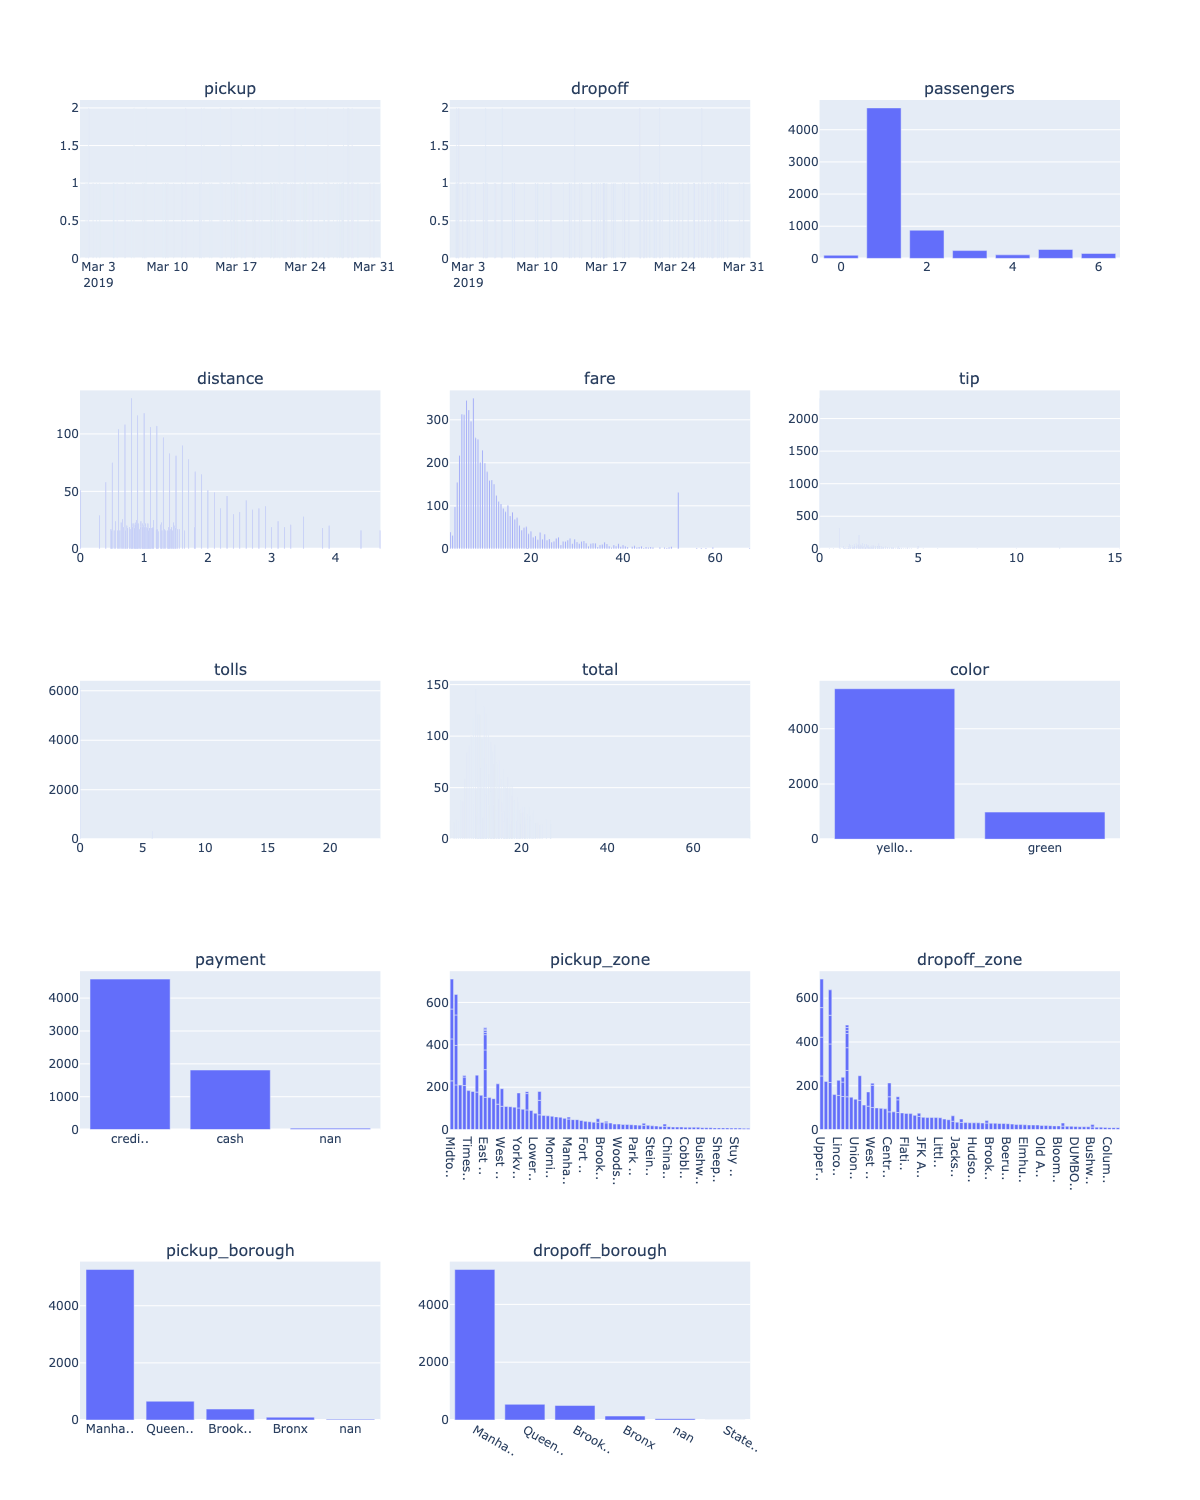

In [30]:
from pandas_plots import tbl, txt
tbl.describe_df(df, 'dataframe', top_n_uniques=5, top_n_chars_in_index=5)
# lol=txt.wrap(list(df['passengers'].sort_values().value_counts().index), max_items_in_line=40)
# lol=wrap('kldjfldjfljö', max_items_in_line=40)
# lol=list(df['passengers'].value_counts().sort_index().index)[:3]
# lol
# txt.wrap(lol)

In [31]:
import pandas as pd

_df = df[["passengers", "distance", "fare", "tip", "tolls", "color"]][:5]
tbl.show_num_df(
    _df.iloc[:, :-1],
    show_totals=True,
    data_bar_axis="x",
    pct_axis="xy",
    precision=0,
)
# _df.info()
# pd.api.types.is_numeric_dtype(_df)

,passengers,distance,fare,tip,tolls,Total
0,1 (1.1%),2 (1.8%),7 (8.0%),2 (2.4%),0,12 (13.4%)
1,1 (1.1%),1 (0.9%),5 (5.7%),0,0,7 (7.7%)
2,1 (1.1%),1 (1.6%),8 (8.5%),2 (2.7%),0,12 (13.9%)
3,1 (1.1%),8 (8.8%),27 (30.7%),6 (7.0%),0,42 (47.6%)
4,3 (3.4%),2 (2.5%),9 (10.2%),1 (1.3%),0,15 (17.4%)
Total,7 (8.0%),14 (15.5%),56 (63.2%),12 (13.4%),0,88 (100.0%)


In [32]:
_df=df[["color", "payment", "total"]]
# _df = df[["passengers", "distance"]][:5]
tbl.pivot_df(
    _df,
    show_totals=True,
    data_bar_axis="",
    pct_axis="xy",
    precision=0,
    heatmap_axis="",
)

payment,,cash,credit card,Total
color,,,,
green,26 (0.0%),4_558 (3.8%),11_603 (9.7%),16_187 (13.6%)
yellow,639 (0.5%),22_036 (18.5%),80_263 (67.4%),102_938 (86.4%)
Total,664 (0.6%),26_594 (22.3%),91_866 (77.1%),119_125 (100.0%)


abc --> cars1 | cars2 | cars3 --> len: 11
ab --> cars1 | cars2 --> len: 7
ac --> cars1 | cars3 --> len: 8
bc --> cars2 | cars3 --> len: 9


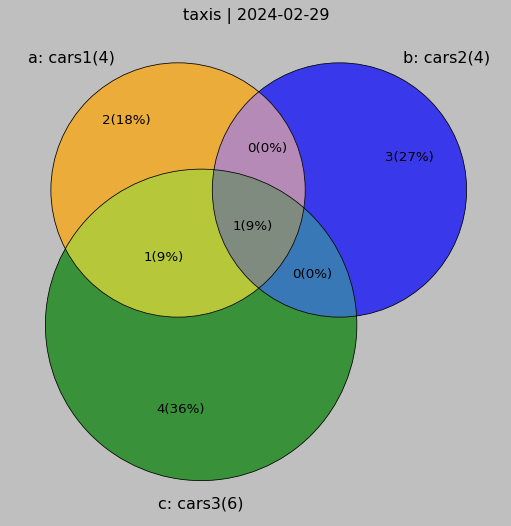

In [33]:
from pandas_plots import ven

set_a = {'ford','ferrari','mercedes', 'bmw'}
set_b = {'opel','bmw','bentley','audi'}
set_c = {'ferrari','bmw','chrysler','renault','peugeot','fiat'}
_df, _details = ven.show_venn3(
    title="taxis",
    a_set=set_a,
    a_label="cars1",
    b_set=set_b,
    b_label="cars2",
    c_set=set_c,
    c_label="cars3",
    verbose=0,
    size=8,
)

In [34]:
# plotly
import plotly_express as px

_fig=px.bar(_df, x=_df.index, y=_df.columns, title="taxis", text_auto=True, orientation="v")
_fig.update_layout(barnorm="percent")

_fig.show()
_df

,all,cars1,cars2
0,bmw,bmw,bmw
1,ford,ford,NaN
2,audi,NaN,audi
3,opel,NaN,opel
4,ferrari,ferrari,NaN
5,mercedes,mercedes,NaN
6,bentley,NaN,bentley


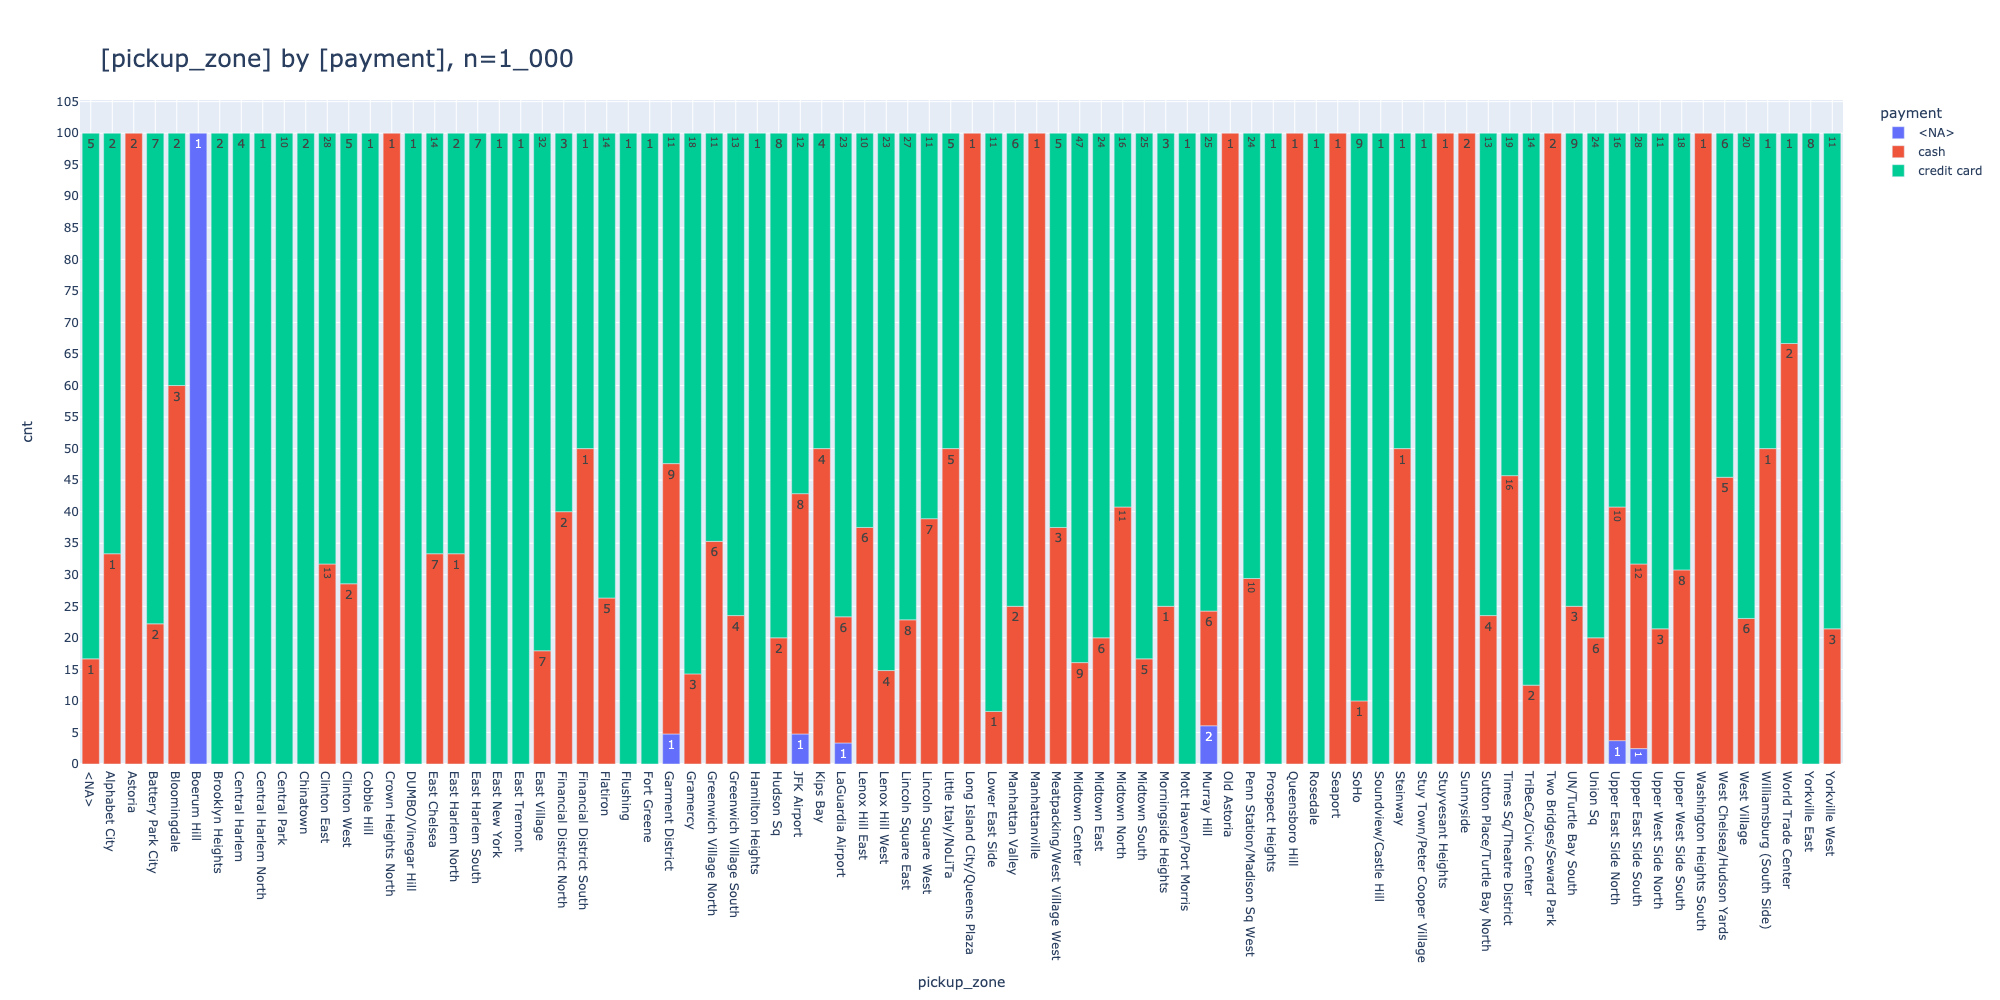

In [35]:
from pandas_plots import pls

_df = df[["payment", "pickup_zone"]][:1000]
pls.plot_stacked_bars(
    _df,
    swap=True,
    orientation="v",
    normalize=False,
    relative=True,
    height=1000,
)

In [52]:
from typing import Literal


def show_num_df(
    df,
    show_total: bool = False,
    total_mode: Literal["sum", "mean", "median", "min", "max", "std", "var", "skew", "kurt"] = "sum",
    heatmap_axis: Literal["x","y","xy", None] = None,
    data_bar_axis: Literal["x","y","xy", None] = None,
    pct_axis: Literal["x", "xy", None] = None,
    swap: bool = False,
    precision: int=0,
):
    """
    A function to display a DataFrame with various options for styling and formatting, including the ability to show totals, apply data bar coloring, and control the display precision. 

    Parameters:
    - df: the DataFrame to display
    - show_totals: a boolean indicating whether to show totals
    - heatmap_axis (Literal["x","y","xy", None], optional): The axis for displaying heatmaps. Defaults to None.
    - data_bar_axis: a Literal indicating the axis for applying data bar coloring ["x","y","xy", None]
    - pct_axis: a Literal indicating the directions for displaying percentages ["x","xy", None]. "x" means sum up pct per column
    - swap: a boolean indicating whether to swap the axes
    - precision: an integer indicating the display precision

    The function returns a styled representation of the DataFrame.
    """
    # * ensure arguments match parameter definition
    if any([df[col].dtype.kind not in ['i','u','f'] for col in df.columns]) == True:
        print(f"❌ table must contain numeric data only")
        return
    
    if (pct_axis and pct_axis not in ["x", "xy"]) or (data_bar_axis and  data_bar_axis not in ["x","y","xy"]) or (heatmap_axis and heatmap_axis not in ["x","y","xy"]):
        print(f"❌ axis not supported")
        return

    if (total_mode and total_mode not in ["sum", "mean", "median", "min", "max", "std", "var", "skew", "kurt"]) :
        print(f"❌ total mode '{total_mode}' not supported")
        return

    theme = os.getenv("THEME") or "light"
    
    # * copy df, do not reference original
    df_ = df.copy() if not swap else df.T.copy()
    
    # * alter _df, add totals
    if show_total:
        df_.loc["Total"] = df_.agg(total_mode,axis=0)
        df_.loc[:, "Total"] = df_.agg(total_mode, axis=1)

    # * derive style
    out = df_.style

    color_highlight = "lightblue" if theme == "light" else "darkgrey"
    color_zeros = "grey" if theme == "light" else "grey"
    color_pct = "grey" if theme == "light" else "yellow"
    color_values = "black" if theme == "light" else "white"
    color_minus = "red" if theme == "light" else "red"
    cmap_heat="Blues" if theme == "light" else "copper" 

    # * apply data bar coloring
    if data_bar_axis:
        out.bar(
            color=f"{color_highlight}",
            axis= 0 if data_bar_axis == "x" else 1 if data_bar_axis == "y" else None,
        )

    # * all cell formatting in one place
    # call hierarchy is not very well organized. all options land here, even if no cellwise formatting is applied
    def format_cell(cell, sum, show_pct):
        if cell == 0:
            return f'<span style="color: {color_zeros}">{cell:.0f}</span>'
        if cell < 0:
            return f'<span style="color: {color_minus}">{cell:_.{precision}f}</span>'
        # * here cell > 0
        if show_pct:
            return f'{cell:_.{precision}f} <span style="color: {color_pct}">({(cell /sum):.1%})</span>'
        return f'{cell:_.{precision}f}'

    # * build pct formatting
    if pct_axis =='x':
        # * totals on either axis influence the sum
        divider = 2 if show_total else 1
        # * cell formatting to each column instead of altering values w/ df.apply
        # * uses dictionary comprehension, and a lambda function with two input variables
        col_sums = df_.sum() / divider
        formatter = {
            col: lambda x, col=col: format_cell(x, col_sums[col], pct_axis) for col in df_.columns
        }

    # ? y is not implemented, needs row wise formatting
    # elif axis=='y':
    #     row_sums = _df.sum(axis=1) / divider
    #     formatter = {
    #         row: lambda x, row=row: format_cell(x, row_sums[row]) for row in _df.index
    #     }

    elif pct_axis=='xy':
        divider = 4 if show_total else 1
        n = df_.sum().sum() / divider
        formatter = {
            col: lambda x, col=col: format_cell(x, n, pct_axis) for col in df_.columns
        }
    else:
        # * 
        formatter = {
            col: lambda x, col=col: format_cell(x, x, False) for col in df_.columns
        }

    out.format(formatter=formatter)

    # * apply fonts for cells
    out.set_properties(**{'font-family': 'Courier'})

    # * apply fonts for th (inkl. index)
    _props=[
                # ("font-size", "10pt"),
                # ("font-weight", "bold"),
                # ("font-family", "Courier"),
                ("text-align", "right")
                ]
    out.set_table_styles(
        [
            dict(selector="th", props=_props),
            # dict(selector="th:nth-child(1)", props=_props),
        ]
    )

    if heatmap_axis:
        out.background_gradient(cmap=cmap_heat, axis=None if heatmap_axis=="xy" else 0 if heatmap_axis=="y" else 1)

    return out

In [56]:
_df = df[["distance", "fare", "tip", "tolls"]][:5]
show_num_df(
    _df,
    show_total="x",
    data_bar_axis="x",
    pct_axis="xy",
    precision=3,
    total_mode="sum",
)
# _df['distance'].mean()

,distance,fare,tip,tolls,Total
0,1.600 (2.0%),7.000 (8.7%),2.150 (2.7%),0,10.750 (13.3%)
1,0.790 (1.0%),5.000 (6.2%),0,0,5.790 (7.2%)
2,1.370 (1.7%),7.500 (9.3%),2.360 (2.9%),0,11.230 (13.9%)
3,7.700 (9.5%),27.000 (33.4%),6.150 (7.6%),0,40.850 (50.5%)
4,2.160 (2.7%),9.000 (11.1%),1.100 (1.4%),0,12.260 (15.2%)
Total,13.620 (16.8%),55.500 (68.6%),11.760 (14.5%),0,80.880 (100.0%)
